# Algorithme de **Grover** — Notebook pédagogique

Objectif : retrouver un élément « marqué » dans une base non structurée de taille $N=2^n$ en $O(\sqrt{N})$ requêtes.

Public : débutants motivés. On traitera $n=2$ (N=4) puis $n=3$ (N=8).


## 1. Installation et imports
```bash
pip install qiskit qiskit-aer  # Si Qiskit n'est pas encore installé
```

In [1]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import math
%matplotlib inline

## 2. Composants de Grover
- **Superposition initiale** (Hadamard sur tous les qubits).
- **Oracle** : ajoute une phase de $-1$ à l'état cible $|w\rangle$ pour le marquer.
- **Diffuseur** (inversion autour de la moyenne) : amplifie la probabilité de $|w\rangle$.
- **Nombre d'itérations** optimal $\approx \left\lfloor \frac{\pi}{4}\sqrt{N} \right\rfloor$.

## 3. Outils : oracle « cible = état binaire »
On marque un état cible (ex : `w='10'` - ce qui équivaut à 2 - pour $n=2$). Implémentation standard : X sur les qubits qui doivent être au préalable à $|0\rangle$, multi-contrôle sur Z, puis X inverses.

In [2]:
def oracle_mark_state(n, bitstring):
    qc = QuantumCircuit(n)
    # Préparation : X sur les qubits à 0 dans la cible
    # NB: on inverse bitstring pour aligner bit de poids faible avec le qubit 0
    for i, b in enumerate(bitstring[::-1]):
        if b == '0':
            qc.x(i)
    # Multi-contrôlé Z (via H + MCX + H sur le dernier qubit)
    if n == 1:
        qc.z(0)
    else:
        qc.h(n-1)
        qc.mcx(list(range(n-1)), n-1)
        qc.h(n-1)
    # Défaire la préparation
    for i, b in enumerate(bitstring[::-1]):
        if b == '0':
            qc.x(i)
    return qc

## 4. Diffuseur (inversion autour de la moyenne)
Schéma classique : $H\circ X$, puis multi-contrôle Z sur $|11\ldots 1\rangle$, puis $X\circ H$.

In [3]:
def diffuser(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    if n == 1:
        qc.z(0)
    else:
        qc.h(n-1)
        qc.mcx(list(range(n-1)), n-1)
        qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    return qc

## 5. Boucle de Grover générique

In [4]:
def grover_search(bitstring, shots=1024):
    n = len(bitstring)
    iters = max(1, int(math.floor((math.pi/4)*math.sqrt(2**n))))
    qc = QuantumCircuit(n, n)
    # Superposition initiale
    qc.h(range(n))
    # Itérations de Grover
    for _ in range(iters):
        qc.compose(oracle_mark_state(n, bitstring), inplace=True)
        qc.compose(diffuser(n), inplace=True)
    # Mesure
    qc.measure(range(n), range(n))
    simulator = AerSimulator()
    result = simulator.run(qc, shots=shots).result()
    counts = result.get_counts()
    return qc, counts, iters

## 6. Démo 1 pour $n=2$ (N=4)
Cible : `w = '10'` (soit l'état $|2\rangle$).

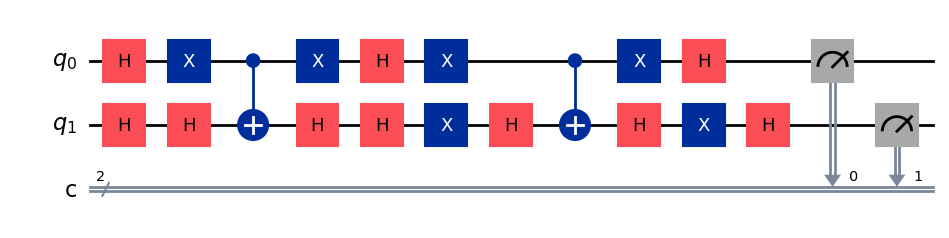

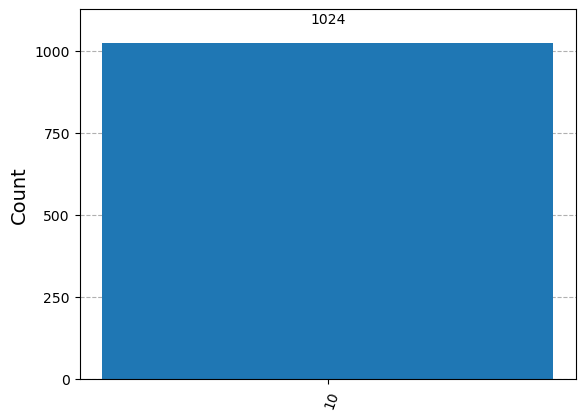

Itérations effectuées: 1. Comptes: {'10': 1024}


In [5]:
qc, counts, iters = grover_search('10')
display(qc.draw('mpl'))
display(plot_histogram(counts))
print(f"Itérations effectuées: {iters}. Comptes: {counts}")

## 7. Démo 2 pour $n=3$ (N=8)
Cible : `w = '101'` (soit l'état $|5\rangle$).

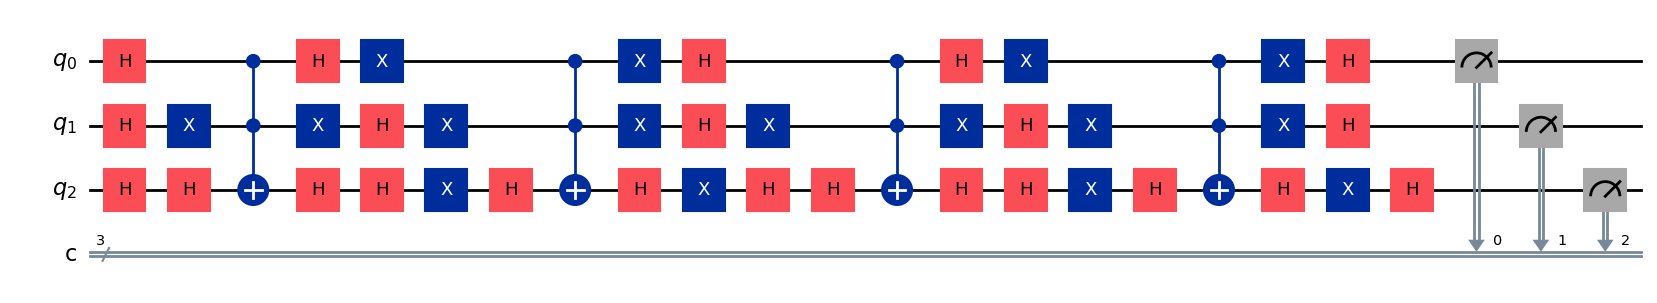

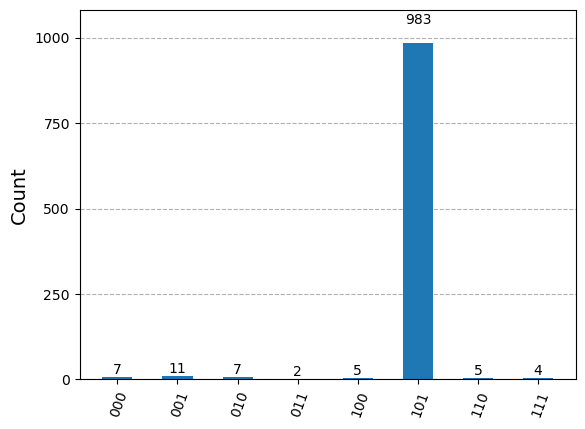

Itérations effectuées: 2. Comptes: {'101': 983, '010': 7, '100': 5, '001': 11, '110': 5, '000': 7, '111': 4, '011': 2}


In [6]:
qc, counts, iters = grover_search('101')
display(qc.draw('mpl'))
display(plot_histogram(counts))
print(f"Itérations effectuées: {iters}. Comptes: {counts}")

## 8. NB
- **Amplification d'amplitude** : l'oracle + diffuseur font tourner l'état dans le sous-espace $\{ |w\rangle, |s\rangle \}$.
- **Nombre d'itérations** : trop peu (\rightarrow\\) faible pic; trop \(\rightarrow\) on re-dépasse le maximum.
- **Limites** : un seul élément marqué (version de base), base non structurée.